# SpecAugment, noise augmentation and attention in spoken language recognition

In this lab, we will use attention to improve the language classification model that is based on convolutional layers.

We will also use SpecAugment (https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html) and noise augmentation for improving the model.


Let's start with the data and baseline model.



In [ ]:
!rm -f 4l_train.zip
!wget --no-check-certificate https://cs.taltech.ee/staff/tanel.alumae/data/4l_train.zip
!rm -f 4l_dev.zip
!wget --no-check-certificate https://cs.taltech.ee/staff/tanel.alumae/data/4l_dev.zip

--2025-05-01 18:56:03--  https://cs.taltech.ee/staff/tanel.alumae/data/4l_train.zip
Resolving cs.taltech.ee (cs.taltech.ee)... 193.40.252.91
Connecting to cs.taltech.ee (cs.taltech.ee)|193.40.252.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145896089 (1.1G) [application/zip]
Saving to: ‘4l_train.zip’

4l_train.zip        100%[===================>]   1.07G  17.4MB/s    in 64s     

2025-05-01 18:57:08 (17.2 MB/s) - ‘4l_train.zip’ saved [1145896089/1145896089]

--2025-05-01 18:57:08--  https://cs.taltech.ee/staff/tanel.alumae/data/4l_dev.zip
Resolving cs.taltech.ee (cs.taltech.ee)... 193.40.252.91
Connecting to cs.taltech.ee (cs.taltech.ee)|193.40.252.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94882458 (90M) [application/zip]
Saving to: ‘4l_dev.zip’

4l_dev.zip          100%[===================>]  90.49M  19.5MB/s    in 5.7s    

2025-05-01 18:57:15 (15.8 MB/s) - ‘4l_dev.zip’ saved [94882458/94882458]



The data originates from Youtube. All utterances have been manually validated via crowdsourcing that they really are in the given language.

In [ ]:
! rm -rf data/train
! mkdir -p data/train
! unzip -q 4l_train.zip -d data/train
! rm -rf data/dev
! unzip -q 4l_dev.zip -d data/dev

In [ ]:
! ls data/train

en  et	fi  ru


In [ ]:
! ls data/dev

en  et	fi  ru


In [ ]:
! ls data/train/en | head

0Chw5dX27tI__U__S1---0140.780-0156.730.wav
0Chw5dX27tI__U__S1---0271.210-0276.800.wav
0Chw5dX27tI__U__S1---0455.640-0463.500.wav
0Chw5dX27tI__U__S1---0568.750-0579.540.wav
0_gE5tzcJiw__U__S83---0594.030-0602.480.wav
0mfbH1n6XJc__U__S14---0034.230-0041.470.wav
0tYjd_CfoS8__U__S102---1488.750-1496.000.wav
0tYjd_CfoS8__U__S176---0555.390-0568.380.wav
0tYjd_CfoS8__U__S186---0492.090-0497.200.wav
0tYjd_CfoS8__U__S377---2346.310-2357.320.wav


In [ ]:
import IPython
IPython.display.Audio("data/train/en/0Chw5dX27tI__U__S1---0140.780-0156.730.wav")

The dataset is somewhat skewed: for some languages there are more training (and development) data. Let's check the number of training examples for each language with a bit of bash hacking:

In [ ]:
! for lang in en et fi ru; do echo -n "$lang "; ls data/train/$lang | wc -l; done

en 811
et 1349
fi 812
ru 857


In [ ]:
import numpy as np
import torch
from torchaudio.compliance.kaldi import fbank, spectrogram

In [ ]:
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange # for displaying a progressbar
import os
from glob import glob


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Let's define a class that can read and represent a dataset.





In [ ]:
import torchaudio

class LanguageDataset(Dataset):
    def __init__(self, root_dir):
        result = [y for x in os.walk(root_dir) for y in glob(os.path.join(x[0], '*.wav'))]
        self.data = []
        for i in tqdm(range(len(result))):
          audio, rate = torchaudio.load(result[i])

          # take language code from directory name
          lang_id = result[i].split("/")[-2]
          self.data.append((lang_id, result[i], audio[0]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
dev_dataset = LanguageDataset("data/dev")

  0%|          | 0/308 [00:00<?, ?it/s]

In [ ]:
train_dataset = LanguageDataset("data/train")

  0%|          | 0/3829 [00:00<?, ?it/s]

Let's also visualize the filterbank features:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import IPython.display as ipd
import numpy as np

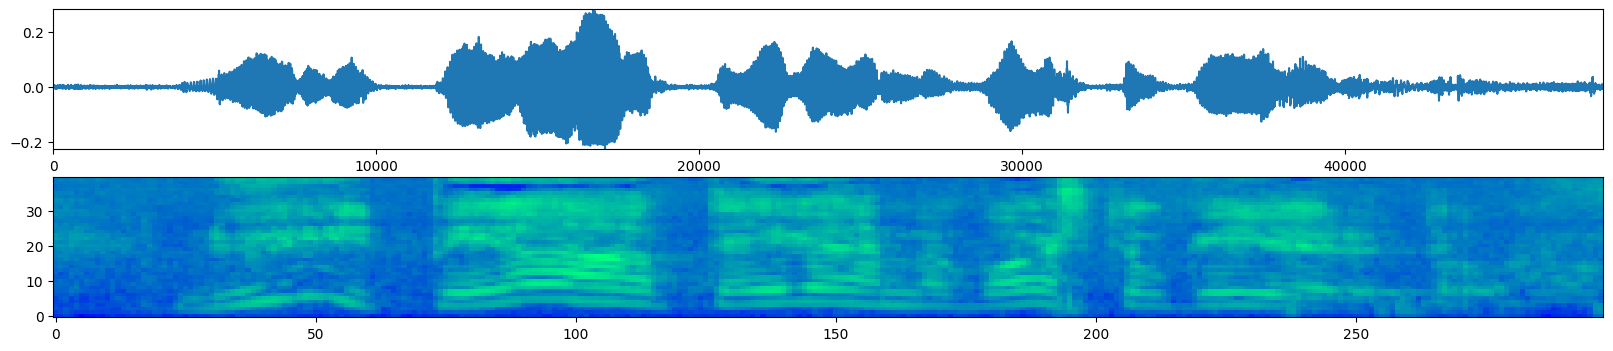

In [ ]:
audio = dev_dataset[1][2][0: 3*16000] # 1st 3 seconds


fbank_feats = fbank(audio.unsqueeze(0), num_mel_bins=40)

f, axarr = plt.subplots(2, sharex=False, figsize=(20, 4))
axarr[0].plot(audio)
axarr[0].margins(0)
axarr[1].imshow(fbank_feats.numpy().T, origin="lower", aspect='auto', cmap=cm.winter)




SpecAugment is a data augmentation technique for audio that randomly replaces a certain filterband or time segment with zeros. It's easy to implement:

In [ ]:
import random

def spec_mask(tensor, dim=0, max_width=3):
    start = random.randrange(0, tensor.shape[dim])
    end = start + random.randrange(1, max_width)
    if end > tensor.shape[dim]:
      end = tensor.shape[dim]
    #print(dim,  torch.arange(start,end))
    result = tensor.index_fill(dim, torch.arange(start,end).to(tensor.device), 0)
    return result

Masking in frequency band:

In [ ]:
freq_masked_spectrogram = spec_mask(fbank_feats, dim=1, max_width=3)

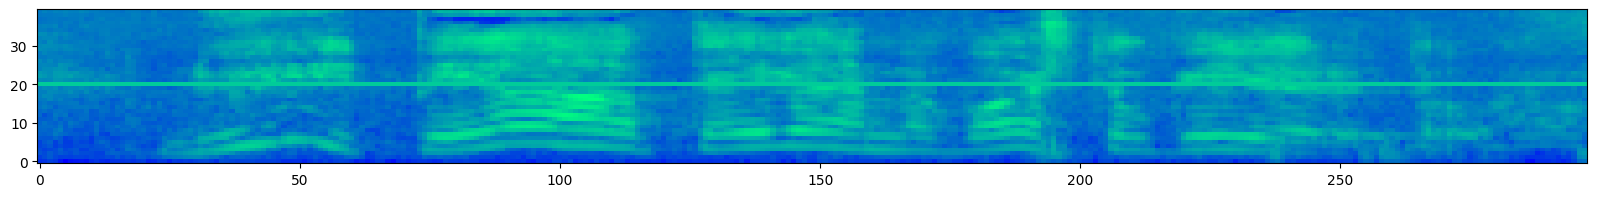

In [ ]:
plt.figure(figsize = (20,2))
plt.imshow(freq_masked_spectrogram.detach().cpu().numpy().T, origin="lower", aspect='auto', cmap=cm.winter)

Masking in time:

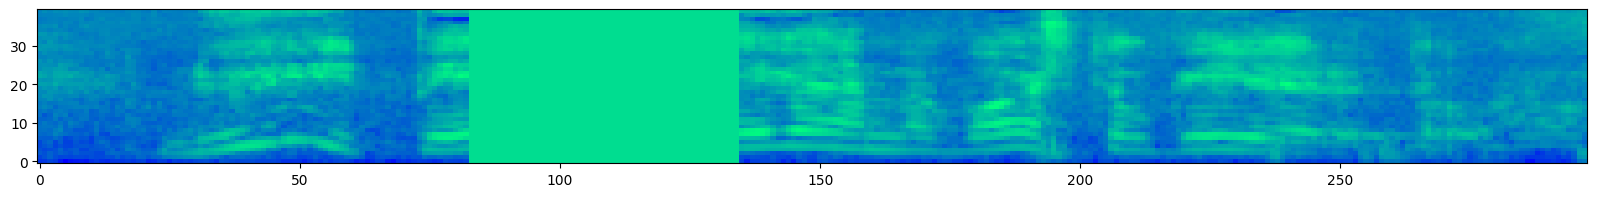

In [ ]:
time_masked_spectrogram = spec_mask(fbank_feats, dim=0, max_width=80)
plt.figure(figsize = (20,2))
plt.imshow(time_masked_spectrogram.detach().cpu().numpy().T, origin="lower", aspect='auto', cmap=cm.winter)

Alright, let's move on.

In [ ]:
lang2id = {"en": 0, "et": 1, "fi": 2, "ru": 3}

We will now define a "collater" function. This function will be passed later to the DataLoaders and will explicitly take care of padding the feature vector sequences of different length to the length of the longest sequence in the batch. This is done by appending zero-filled vectors to the end.

In [ ]:
import random
from functools import partial
def collater(samples, extract_chunks=False, chunk_length_in_secs=3.0, do_spec_augment=False):

    if len(samples) == 0:
        return {}

    audios = [s[2] for s in samples]
    if extract_chunks:
      for i in range(len(audios)):
        chunk_len_in_samples = int(chunk_length_in_secs * 16000)
        audio_tensor = audios[i]
        if len(audio_tensor) - chunk_len_in_samples - 1 <= 0:
          start = 0
        else:
          start = random.randint(0, len(audio_tensor) - chunk_len_in_samples - 1)
        stop = start + chunk_len_in_samples

        audios[i] = audio_tensor[start:stop]

    audio_lengths = torch.tensor([len(audio) for audio in audios]).float()
    audio_lengths /= audio_lengths.max()
    features = [fbank(audio.unsqueeze(0), num_mel_bins=40) for audio in audios]
    # mean normalization: make sure that the features are centered around 0
    features = [feat - torch.mean(feat, dim=0) for feat in features]

    if do_spec_augment:
      features = [spec_mask(feat, dim=1, max_width=3) for feat in features]
      features = [spec_mask(feat, dim=0, max_width=100) for feat in features]

    collated_features = torch.nn.utils.rnn.pad_sequence(features, batch_first=True)


    batch = {
        "lang": torch.tensor([lang2id[s[0]] for s in samples]),
        "features": collated_features,
        "lengthts": audio_lengths
    }
    return batch

In [ ]:
# Training data will use chunking
train_iter = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=partial(collater, extract_chunks=True, do_spec_augment=False), drop_last=True, num_workers=2)
# Dev data will not use chunking
dev_iter = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=partial(collater, extract_chunks=False, do_spec_augment=False))



In [ ]:
next(iter(train_iter))

{'lang': tensor([2, 3, 0, 0, 3, 3, 1, 3, 1, 3, 0, 2, 1, 2, 1, 1, 2, 0, 3, 1, 1, 0, 2, 0,
         1, 0, 3, 2, 3, 3, 1, 1]),
 'features': tensor([[[ 1.3097e+00,  9.9520e-01,  2.1829e+00,  ..., -1.5698e+00,
           -8.1903e-01, -6.5245e-01],
          [ 1.7195e+00,  1.1602e+00,  2.1964e+00,  ..., -1.7440e+00,
           -1.5078e+00, -1.6093e+00],
          [ 1.5412e+00,  1.2029e+00,  2.2759e+00,  ..., -9.4557e-01,
           -6.7958e-01, -1.3868e+00],
          ...,
          [ 1.7601e+00,  1.2607e+00,  2.1361e+00,  ...,  1.7984e+00,
            2.1937e-01,  1.8767e+00],
          [ 1.4945e+00,  9.4412e-01,  2.0304e+00,  ...,  1.6740e+00,
            7.1312e-01,  2.1398e+00],
          [ 1.6343e+00,  9.5573e-01,  2.0164e+00,  ...,  9.8390e-01,
           -1.4941e-01,  1.6611e+00]],
 
         [[-1.1956e+00, -6.9632e-01, -1.2542e+00,  ..., -9.0151e-01,
           -1.2101e+00, -1.3710e+00],
          [-9.1648e-04,  2.6407e-01,  4.2517e-01,  ..., -1.7906e+00,
           -2.0479e+00, -2.0

Now we can define our model.

Note how the CNN model is very similar to the model we used for text classification. Only here we don't have to use word embeddings, because the speech features already look a bit like embeddings.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

In [ ]:
class SpeechCnn(nn.Module):

  def __init__(self, num_classes, feature_dim, dropout_prob=0.2):
    super(SpeechCnn, self).__init__()
    self.num_classes = num_classes
    self.layers = nn.Sequential(
        nn.BatchNorm1d(feature_dim),
        nn.Conv1d(feature_dim, 128, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),

        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3, stride=2),
        nn.ReLU(inplace=True),

        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3, stride=2),
        nn.ReLU(inplace=True),

        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3, stride=2),
        nn.ReLU(inplace=True)
    )


    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(128, num_classes)

  def forward(self, x):
    # Conv1d takes in (batch, channels, seq_len), but raw signal is (batch, seq_len, channels)
    x = x.permute(0, 2, 1).contiguous()

    x = self.layers(x)

    x = F.max_pool1d(x, x.size(2))
    #print(x.shape)
    x = x.view(-1, 128)
    #print(x.shape)
    x = self.dropout(x)
    logit = self.fc(x)
    return logit

In [ ]:
from tqdm import tqdm, trange # for displaying a progressbar

def train(model, num_epochs, train_iter, dev_iter, device,  lr_decay=0.5):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  # We multiply learning rate by lr_decay if the model's loss on dev data hasn't decreased for 2 epochs
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=lr_decay, patience=1)

  steps = 0
  best_acc = 0
  last_step = 0

  for epoch in range(1, num_epochs+1):
    print("Starting epoch %d" % epoch)
    for batch in tqdm(train_iter):
      # set training mode
      model.train()
      fbank = batch["features"].to(device)

      target = batch["lang"].to(device)
      optimizer.zero_grad()
      logit = model(fbank)
      loss = F.cross_entropy(logit, target)
      loss.backward()
      optimizer.step()

    dev_acc, dev_loss = evaluate("dev", dev_iter, model)
    lr_scheduler.step(dev_loss)


def evaluate(name, data_iter, model):
  # set evaluation mode (turns off dropout)
  model.eval()
  corrects, avg_loss = 0, 0
  for batch in data_iter:
    fbank = batch["features"].to(device)
    target = batch["lang"].to(device)

    logit = model(fbank)
    loss = F.cross_entropy(logit, target,  reduction='sum')

    avg_loss += loss.item()
    corrects += (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()

  size = len(data_iter.dataset)
  avg_loss /= size
  accuracy = 100.0 * float(corrects)/size
  print('  Evaluation on {} - loss: {:.6f}  acc: {:.4f}%({}/{})'.format(name,
                                                                        avg_loss,
                                                                        accuracy,
                                                                        corrects,
                                                                        size))
  return accuracy, avg_loss

First, we train a model without SpecAugment




In [ ]:
model = SpeechCnn(4, 40).to(device)
train(model, 20, train_iter, dev_iter, device=device)

Starting epoch 1


100%|██████████| 119/119 [00:09<00:00, 12.85it/s]


  Evaluation on dev - loss: 1.105274  acc: 53.8961%(166/308)
Starting epoch 2


100%|██████████| 119/119 [00:09<00:00, 12.92it/s]


  Evaluation on dev - loss: 1.006904  acc: 59.0909%(182/308)
Starting epoch 3


100%|██████████| 119/119 [00:09<00:00, 13.19it/s]


  Evaluation on dev - loss: 0.865130  acc: 62.3377%(192/308)
Starting epoch 4


100%|██████████| 119/119 [00:09<00:00, 13.17it/s]


  Evaluation on dev - loss: 0.772572  acc: 67.2078%(207/308)
Starting epoch 5


100%|██████████| 119/119 [00:09<00:00, 12.93it/s]


  Evaluation on dev - loss: 0.934170  acc: 59.0909%(182/308)
Starting epoch 6


100%|██████████| 119/119 [00:07<00:00, 14.95it/s]


  Evaluation on dev - loss: 0.691055  acc: 73.3766%(226/308)
Starting epoch 7


100%|██████████| 119/119 [00:07<00:00, 15.00it/s]


  Evaluation on dev - loss: 0.790661  acc: 70.7792%(218/308)
Starting epoch 8


100%|██████████| 119/119 [00:08<00:00, 14.09it/s]


  Evaluation on dev - loss: 0.699686  acc: 74.0260%(228/308)
Starting epoch 9


100%|██████████| 119/119 [00:08<00:00, 13.22it/s]


  Evaluation on dev - loss: 0.634272  acc: 75.9740%(234/308)
Starting epoch 10


100%|██████████| 119/119 [00:09<00:00, 13.02it/s]


  Evaluation on dev - loss: 0.576710  acc: 78.8961%(243/308)
Starting epoch 11


100%|██████████| 119/119 [00:09<00:00, 13.22it/s]


  Evaluation on dev - loss: 0.621303  acc: 73.3766%(226/308)
Starting epoch 12


100%|██████████| 119/119 [00:08<00:00, 13.98it/s]


  Evaluation on dev - loss: 0.576519  acc: 79.2208%(244/308)
Starting epoch 13


100%|██████████| 119/119 [00:07<00:00, 14.88it/s]


  Evaluation on dev - loss: 0.547502  acc: 78.2468%(241/308)
Starting epoch 14


100%|██████████| 119/119 [00:08<00:00, 14.82it/s]


  Evaluation on dev - loss: 0.586013  acc: 78.2468%(241/308)
Starting epoch 15


100%|██████████| 119/119 [00:08<00:00, 13.27it/s]


  Evaluation on dev - loss: 0.750265  acc: 72.0779%(222/308)
Starting epoch 16


100%|██████████| 119/119 [00:09<00:00, 12.37it/s]


  Evaluation on dev - loss: 0.542609  acc: 77.9221%(240/308)
Starting epoch 17


100%|██████████| 119/119 [00:09<00:00, 12.73it/s]


  Evaluation on dev - loss: 0.519780  acc: 81.4935%(251/308)
Starting epoch 18


100%|██████████| 119/119 [00:09<00:00, 12.58it/s]


  Evaluation on dev - loss: 0.541460  acc: 82.4675%(254/308)
Starting epoch 19


100%|██████████| 119/119 [00:09<00:00, 13.08it/s]


  Evaluation on dev - loss: 0.497128  acc: 81.1688%(250/308)
Starting epoch 20


100%|██████████| 119/119 [00:08<00:00, 14.62it/s]


  Evaluation on dev - loss: 0.453612  acc: 84.0909%(259/308)


Now, we try Specaugment:

In [ ]:
# Training data will use chunking and SpecAugment
train_iter_specaug = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=partial(collater, extract_chunks=True, do_spec_augment=True), drop_last=True)

model = SpeechCnn(4, 40).to(device)
# we also have to increase the number of epochs when SpecAugment is activated!
train(model, 40, train_iter_specaug, dev_iter, device=device)

Starting epoch 1


100%|██████████| 119/119 [00:10<00:00, 11.66it/s]


  Evaluation on dev - loss: 1.043211  acc: 57.7922%(178/308)
Starting epoch 2


100%|██████████| 119/119 [00:10<00:00, 11.49it/s]


  Evaluation on dev - loss: 1.005465  acc: 59.4156%(183/308)
Starting epoch 3


100%|██████████| 119/119 [00:10<00:00, 11.38it/s]


  Evaluation on dev - loss: 1.004122  acc: 62.3377%(192/308)
Starting epoch 4


100%|██████████| 119/119 [00:10<00:00, 11.30it/s]


  Evaluation on dev - loss: 0.826856  acc: 68.8312%(212/308)
Starting epoch 5


100%|██████████| 119/119 [00:10<00:00, 11.45it/s]


  Evaluation on dev - loss: 0.878355  acc: 68.1818%(210/308)
Starting epoch 6


100%|██████████| 119/119 [00:10<00:00, 11.50it/s]


  Evaluation on dev - loss: 1.000621  acc: 56.1688%(173/308)
Starting epoch 7


100%|██████████| 119/119 [00:10<00:00, 11.60it/s]


  Evaluation on dev - loss: 0.742605  acc: 70.4545%(217/308)
Starting epoch 8


100%|██████████| 119/119 [00:10<00:00, 11.44it/s]


  Evaluation on dev - loss: 0.674212  acc: 74.3506%(229/308)
Starting epoch 9


100%|██████████| 119/119 [00:10<00:00, 11.57it/s]


  Evaluation on dev - loss: 0.635513  acc: 75.3247%(232/308)
Starting epoch 10


100%|██████████| 119/119 [00:10<00:00, 11.41it/s]


  Evaluation on dev - loss: 0.624986  acc: 76.2987%(235/308)
Starting epoch 11


100%|██████████| 119/119 [00:10<00:00, 11.15it/s]


  Evaluation on dev - loss: 0.600113  acc: 79.8701%(246/308)
Starting epoch 12


100%|██████████| 119/119 [00:10<00:00, 11.26it/s]


  Evaluation on dev - loss: 0.608087  acc: 78.2468%(241/308)
Starting epoch 13


100%|██████████| 119/119 [00:10<00:00, 11.18it/s]


  Evaluation on dev - loss: 0.645200  acc: 75.6494%(233/308)
Starting epoch 14


100%|██████████| 119/119 [00:10<00:00, 11.14it/s]


  Evaluation on dev - loss: 0.563802  acc: 80.5195%(248/308)
Starting epoch 15


100%|██████████| 119/119 [00:10<00:00, 11.22it/s]


  Evaluation on dev - loss: 0.580737  acc: 78.5714%(242/308)
Starting epoch 16


100%|██████████| 119/119 [00:10<00:00, 11.32it/s]


  Evaluation on dev - loss: 0.539378  acc: 80.5195%(248/308)
Starting epoch 17


100%|██████████| 119/119 [00:10<00:00, 11.23it/s]


  Evaluation on dev - loss: 0.505190  acc: 84.0909%(259/308)
Starting epoch 18


100%|██████████| 119/119 [00:10<00:00, 11.39it/s]


  Evaluation on dev - loss: 0.558277  acc: 80.5195%(248/308)
Starting epoch 19


100%|██████████| 119/119 [00:10<00:00, 11.35it/s]


  Evaluation on dev - loss: 0.586703  acc: 78.2468%(241/308)
Starting epoch 20


100%|██████████| 119/119 [00:10<00:00, 11.38it/s]


  Evaluation on dev - loss: 0.513869  acc: 80.8442%(249/308)
Starting epoch 21


100%|██████████| 119/119 [00:10<00:00, 11.17it/s]


  Evaluation on dev - loss: 0.519250  acc: 78.8961%(243/308)
Starting epoch 22


100%|██████████| 119/119 [00:10<00:00, 11.30it/s]


  Evaluation on dev - loss: 0.504975  acc: 80.8442%(249/308)
Starting epoch 23


100%|██████████| 119/119 [00:10<00:00, 11.63it/s]


  Evaluation on dev - loss: 0.503392  acc: 80.5195%(248/308)
Starting epoch 24


100%|██████████| 119/119 [00:10<00:00, 11.72it/s]


  Evaluation on dev - loss: 0.490700  acc: 82.1429%(253/308)
Starting epoch 25


100%|██████████| 119/119 [00:09<00:00, 11.95it/s]


  Evaluation on dev - loss: 0.493444  acc: 82.1429%(253/308)
Starting epoch 26


100%|██████████| 119/119 [00:09<00:00, 12.05it/s]


  Evaluation on dev - loss: 0.491843  acc: 80.8442%(249/308)
Starting epoch 27


100%|██████████| 119/119 [00:09<00:00, 11.90it/s]


  Evaluation on dev - loss: 0.499667  acc: 81.1688%(250/308)
Starting epoch 28


100%|██████████| 119/119 [00:09<00:00, 12.03it/s]


  Evaluation on dev - loss: 0.508767  acc: 80.1948%(247/308)
Starting epoch 29


100%|██████████| 119/119 [00:10<00:00, 11.77it/s]


  Evaluation on dev - loss: 0.496903  acc: 80.5195%(248/308)
Starting epoch 30


100%|██████████| 119/119 [00:10<00:00, 11.58it/s]


  Evaluation on dev - loss: 0.493890  acc: 80.8442%(249/308)
Starting epoch 31


100%|██████████| 119/119 [00:10<00:00, 11.36it/s]


  Evaluation on dev - loss: 0.496061  acc: 80.1948%(247/308)
Starting epoch 32


100%|██████████| 119/119 [00:10<00:00, 11.63it/s]


  Evaluation on dev - loss: 0.494143  acc: 80.1948%(247/308)
Starting epoch 33


100%|██████████| 119/119 [00:10<00:00, 11.57it/s]


  Evaluation on dev - loss: 0.491440  acc: 80.1948%(247/308)
Starting epoch 34


100%|██████████| 119/119 [00:10<00:00, 11.17it/s]


  Evaluation on dev - loss: 0.492549  acc: 81.1688%(250/308)
Starting epoch 35


100%|██████████| 119/119 [00:10<00:00, 11.60it/s]


  Evaluation on dev - loss: 0.490189  acc: 80.5195%(248/308)
Starting epoch 36


100%|██████████| 119/119 [00:10<00:00, 11.58it/s]


  Evaluation on dev - loss: 0.493226  acc: 80.8442%(249/308)
Starting epoch 37


100%|██████████| 119/119 [00:10<00:00, 11.59it/s]


  Evaluation on dev - loss: 0.492994  acc: 81.1688%(250/308)
Starting epoch 38


100%|██████████| 119/119 [00:10<00:00, 11.57it/s]


  Evaluation on dev - loss: 0.494655  acc: 80.5195%(248/308)
Starting epoch 39


100%|██████████| 119/119 [00:10<00:00, 11.20it/s]


  Evaluation on dev - loss: 0.495577  acc: 80.5195%(248/308)
Starting epoch 40


100%|██████████| 119/119 [00:10<00:00, 11.42it/s]


  Evaluation on dev - loss: 0.492905  acc: 80.5195%(248/308)


Now we'll experiment with another type of augmentation -- noise and reverb augmentation. The idea behind this to artificially corrupt the training data with backbround noise or room reverberation effects. A pretty good and easy to use implementation for this is available in the `speechbrain` package. We have to install a specific version of the package, since the augmentation implementation is refactored in later versions and is much more complicated now.

In [ ]:
! pip install speechbrain==0.5.16

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We'll now construct the object that can corrupt audio data. We can specify, how likely each of the augmentation effetcs is, and also specify some noising parameters. We also have to specify the folder with noise and room reverbs where it will automatically download the required data:

In [ ]:
#torchaudio.set_audio_backend("soundfile")

In [ ]:
import speechbrain.lobes.augment
add_noise = speechbrain.lobes.augment.EnvCorrupt(openrir_max_noise_len=3.0, reverb_prob=0.5, noise_prob=0.5, noise_snr_low=0, noise_snr_high=15, rir_scale_factor=1.0,  openrir_folder="openrir")

RIRS_NOISES.zip?rlkey=01ymylca0an1nc7tlpdt2bjif&dl=1: 816MB [00:13, 58.5MB/s]                           


Extracting openrir/rirs_noises.zip to openrir


In [ ]:
noisy_wav = add_noise(dev_dataset[10][2].unsqueeze(0), torch.tensor([1.0]))

Let's hear a sample of a noised audio sample:

In [ ]:
IPython.display.Audio(dev_dataset[10][2].unsqueeze(0), rate=16000)

In [ ]:
IPython.display.Audio(noisy_wav, rate=16000)

In [ ]:
import random
from functools import partial
def noising_collater(samples, extract_chunks=False, chunk_length_in_secs=3.0, do_add_noise=False):

    if len(samples) == 0:
        return {}

    audios = [s[2] for s in samples]
    if extract_chunks:
      for i in range(len(audios)):
        chunk_len_in_samples = int(chunk_length_in_secs * 16000)
        audio_tensor = audios[i]
        if len(audio_tensor) - chunk_len_in_samples - 1 <= 0:
          start = 0
        else:
          start = random.randint(0, len(audio_tensor) - chunk_len_in_samples - 1)
        stop = start + chunk_len_in_samples

        audios[i] = audio_tensor[start:stop]

    audio_lengths = torch.tensor([len(audio) for audio in audios]).float()
    audio_lengths /= audio_lengths.max()
    if do_add_noise:
      collated_audios = torch.nn.utils.rnn.pad_sequence(audios, batch_first=True)
      audios = add_noise(collated_audios, audio_lengths)

    features = [fbank(audio.unsqueeze(0), num_mel_bins=40) for audio in audios]
    # mean normalization: make sure that the features are centered around 0
    features = [feat - torch.mean(feat, dim=0) for feat in features]
    collated_features = torch.nn.utils.rnn.pad_sequence(features, batch_first=True)

    batch = {
        "lang": torch.tensor([lang2id[s[0]] for s in samples]),
        "features": collated_features,
        "lengthts": audio_lengths
    }
    return batch

In [ ]:
train_iter_noisy = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=partial(noising_collater, extract_chunks=True, do_add_noise=True), drop_last=True, num_workers=2)

In [ ]:
model = SpeechCnn(4, 40).to(device)
# we also have to increase the number of epochs when noise augmentation is activated
train(model, 40, train_iter_noisy, dev_iter, device=device)

Starting epoch 1


100%|██████████| 119/119 [00:26<00:00,  4.48it/s]


  Evaluation on dev - loss: 1.221237  acc: 39.2857%(121/308)
Starting epoch 2


100%|██████████| 119/119 [00:27<00:00,  4.27it/s]


  Evaluation on dev - loss: 1.037770  acc: 56.4935%(174/308)
Starting epoch 3


100%|██████████| 119/119 [00:25<00:00,  4.59it/s]


  Evaluation on dev - loss: 0.947452  acc: 60.7143%(187/308)
Starting epoch 4


100%|██████████| 119/119 [00:23<00:00,  5.00it/s]


  Evaluation on dev - loss: 0.966335  acc: 62.0130%(191/308)
Starting epoch 5


100%|██████████| 119/119 [00:24<00:00,  4.85it/s]


  Evaluation on dev - loss: 0.815836  acc: 67.8571%(209/308)
Starting epoch 6


100%|██████████| 119/119 [00:24<00:00,  4.80it/s]


  Evaluation on dev - loss: 0.775014  acc: 67.8571%(209/308)
Starting epoch 7


100%|██████████| 119/119 [00:25<00:00,  4.70it/s]


  Evaluation on dev - loss: 0.886566  acc: 67.5325%(208/308)
Starting epoch 8


100%|██████████| 119/119 [00:23<00:00,  5.01it/s]


  Evaluation on dev - loss: 0.831427  acc: 68.8312%(212/308)
Starting epoch 9


100%|██████████| 119/119 [00:28<00:00,  4.19it/s]


  Evaluation on dev - loss: 0.636498  acc: 77.5974%(239/308)
Starting epoch 10


100%|██████████| 119/119 [00:27<00:00,  4.38it/s]


  Evaluation on dev - loss: 0.614496  acc: 76.2987%(235/308)
Starting epoch 11


100%|██████████| 119/119 [00:26<00:00,  4.49it/s]


  Evaluation on dev - loss: 0.566424  acc: 79.5455%(245/308)
Starting epoch 12


100%|██████████| 119/119 [00:24<00:00,  4.88it/s]


  Evaluation on dev - loss: 0.552894  acc: 81.8182%(252/308)
Starting epoch 13


100%|██████████| 119/119 [00:27<00:00,  4.29it/s]


  Evaluation on dev - loss: 0.602897  acc: 80.1948%(247/308)
Starting epoch 14


100%|██████████| 119/119 [00:23<00:00,  4.96it/s]


  Evaluation on dev - loss: 0.568510  acc: 79.8701%(246/308)
Starting epoch 15


100%|██████████| 119/119 [00:26<00:00,  4.57it/s]


  Evaluation on dev - loss: 0.551362  acc: 79.2208%(244/308)
Starting epoch 16


100%|██████████| 119/119 [00:27<00:00,  4.32it/s]


  Evaluation on dev - loss: 0.541382  acc: 82.4675%(254/308)
Starting epoch 17


100%|██████████| 119/119 [00:27<00:00,  4.40it/s]


  Evaluation on dev - loss: 0.510843  acc: 81.1688%(250/308)
Starting epoch 18


100%|██████████| 119/119 [00:26<00:00,  4.43it/s]


  Evaluation on dev - loss: 0.536415  acc: 79.8701%(246/308)
Starting epoch 19


100%|██████████| 119/119 [00:26<00:00,  4.57it/s]


  Evaluation on dev - loss: 0.501949  acc: 82.4675%(254/308)
Starting epoch 20


100%|██████████| 119/119 [00:26<00:00,  4.53it/s]


  Evaluation on dev - loss: 0.490407  acc: 83.1169%(256/308)
Starting epoch 21


100%|██████████| 119/119 [00:26<00:00,  4.50it/s]


  Evaluation on dev - loss: 0.470678  acc: 85.3896%(263/308)
Starting epoch 22


100%|██████████| 119/119 [00:25<00:00,  4.64it/s]


  Evaluation on dev - loss: 0.495658  acc: 82.4675%(254/308)
Starting epoch 23


100%|██████████| 119/119 [00:24<00:00,  4.78it/s]


  Evaluation on dev - loss: 0.476747  acc: 84.0909%(259/308)
Starting epoch 24


100%|██████████| 119/119 [00:26<00:00,  4.41it/s]


  Evaluation on dev - loss: 0.464618  acc: 82.7922%(255/308)
Starting epoch 25


100%|██████████| 119/119 [00:28<00:00,  4.22it/s]


  Evaluation on dev - loss: 0.453667  acc: 84.7403%(261/308)
Starting epoch 26


100%|██████████| 119/119 [00:28<00:00,  4.21it/s]


  Evaluation on dev - loss: 0.450004  acc: 85.0649%(262/308)
Starting epoch 27


100%|██████████| 119/119 [00:25<00:00,  4.58it/s]


  Evaluation on dev - loss: 0.484711  acc: 80.8442%(249/308)
Starting epoch 28


100%|██████████| 119/119 [00:26<00:00,  4.46it/s]


  Evaluation on dev - loss: 0.464206  acc: 86.0390%(265/308)
Starting epoch 29


100%|██████████| 119/119 [00:24<00:00,  4.82it/s]


  Evaluation on dev - loss: 0.445840  acc: 85.3896%(263/308)
Starting epoch 30


100%|██████████| 119/119 [00:27<00:00,  4.30it/s]


  Evaluation on dev - loss: 0.449076  acc: 84.4156%(260/308)
Starting epoch 31


100%|██████████| 119/119 [00:25<00:00,  4.72it/s]


  Evaluation on dev - loss: 0.439189  acc: 85.7143%(264/308)
Starting epoch 32


100%|██████████| 119/119 [00:24<00:00,  4.84it/s]


  Evaluation on dev - loss: 0.450334  acc: 84.0909%(259/308)
Starting epoch 33


100%|██████████| 119/119 [00:25<00:00,  4.64it/s]


  Evaluation on dev - loss: 0.429309  acc: 86.3636%(266/308)
Starting epoch 34


100%|██████████| 119/119 [00:25<00:00,  4.66it/s]


  Evaluation on dev - loss: 0.421050  acc: 87.3377%(269/308)
Starting epoch 35


100%|██████████| 119/119 [00:24<00:00,  4.84it/s]


  Evaluation on dev - loss: 0.434581  acc: 84.4156%(260/308)
Starting epoch 36


100%|██████████| 119/119 [00:21<00:00,  5.43it/s]


  Evaluation on dev - loss: 0.421738  acc: 84.4156%(260/308)
Starting epoch 37


100%|██████████| 119/119 [00:25<00:00,  4.62it/s]


  Evaluation on dev - loss: 0.417266  acc: 85.7143%(264/308)
Starting epoch 38


100%|██████████| 119/119 [00:24<00:00,  4.92it/s]


  Evaluation on dev - loss: 0.419878  acc: 86.0390%(265/308)
Starting epoch 39


100%|██████████| 119/119 [00:23<00:00,  5.01it/s]


  Evaluation on dev - loss: 0.418658  acc: 86.3636%(266/308)
Starting epoch 40


100%|██████████| 119/119 [00:23<00:00,  5.08it/s]


  Evaluation on dev - loss: 0.418976  acc: 86.0390%(265/308)


In my experience, noise augmentation usually gives slightly better results than SpecAugment, but sometimes not. It of course also depends a lot on your test data.

Now, let's define our model with attention.

We will experiment with two types of attention: simple and multi-head key-value-query based.

The simple attention we can implement ourself:

In [ ]:
class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)

    def forward(self, batch_rep):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension

        attention_weight:
            att_w : size (N, T, 1)

        return:
            utter_rep: size (N, H)
        """
        att_w = nn.functional.softmax(self.W(batch_rep).squeeze(-1), dim=1).unsqueeze(-1)
        utter_rep = torch.sum(batch_rep * att_w, dim=1)

        return utter_rep

class SpeechCnnAttention(nn.Module):

  def __init__(self, num_classes, feature_dim,  attention_size=64, dropout_prob=0.2):
    super(SpeechCnnAttention, self).__init__()
    self.num_classes = num_classes

    # Utterance-level attention network
    # Transforms outputs of convolutional layers to the same dim as the attention vector
    self.utterance_attention = nn.Linear(128, attention_size)

    # Attention vector to take dot-product with
    self.utterance_context_vector = nn.Linear(attention_size, 1, bias=False)

    self.layers = nn.Sequential(
        nn.BatchNorm1d(feature_dim),
        nn.Conv1d(feature_dim, 128, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),

        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3, stride=2),
        nn.ReLU(inplace=True),

        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3, stride=2),
        nn.ReLU(inplace=True),

        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3, stride=2),
        nn.ReLU(inplace=True)
    )

    self.pooling = SelfAttentionPooling(128)

    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(128, num_classes)



  def forward(self, x):
    # Conv1d takes in (batch, features, seq_len), but raw signal is (batch, seq_len, features)
    x = x.permute(0, 2, 1).contiguous()
    # Compute the output of the main layers
    x = self.layers(x)

    # Convert it back to shape (batch, features, seq_len)
    x = x.permute(0, 2, 1).contiguous()

    x = self.pooling(x)

    x = self.dropout(x)
    logit = self.fc(x)
    return logit

In [ ]:
model = SpeechCnnAttention(4, 40).to(device)
train(model, 20, train_iter, dev_iter, device=device)

Let's also try with query-key-value based attention.

For this, we can use Pytorch's MultiheadAttention class. We also need two new minilayers to transform output from CNN to key and value. The key is compared to the DNN's query vector and the value is used as to compute the output of the attention layer.



In [ ]:
class SpeechCnnAttention2(nn.Module):

  def __init__(self, num_classes, feature_dim,  attention_dim=64, num_attention_heads=1, dropout_prob=0.2):
    super(SpeechCnnAttention2, self).__init__()
    self.num_classes = num_classes
    self.attention_dim = attention_dim

    # Attention vector to take dot-product with
    self.utterance_query_vector = nn.Parameter(torch.FloatTensor(attention_dim))
    torch.nn.init.uniform_(self.utterance_query_vector)

    self.cnn_to_key = nn.Linear(128, attention_dim, bias=False)
    self.cnn_to_value = nn.Linear(128, attention_dim, bias=False)

    self.layers = nn.Sequential(
        nn.BatchNorm1d(feature_dim),
        nn.Conv1d(feature_dim, 128, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),

        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3, stride=2),
        nn.ReLU(inplace=True),

        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3, stride=2),
        nn.ReLU(inplace=True),

        nn.BatchNorm1d(128),
        nn.Conv1d(128, 128, kernel_size=3, stride=2),
        nn.ReLU(inplace=True)
    )

    self.multihead_attention = nn.MultiheadAttention(attention_dim * num_attention_heads, num_heads=num_attention_heads, dropout=dropout_prob)

    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(attention_dim * num_attention_heads, num_classes)


  # We extracted the method that calculates output from the residual layers and the
  # attention weights to a seperate method, so that we can call it independantly later.
  def compute_layers_and_attention_scores(self, x):
    # Conv1d takes in (batch, features, seq_len), but raw signal is (batch, seq_len, features)
    # Convert it back to shape (batch, features, seq_len)
    x = x.permute(0, 2, 1).contiguous()
    # Compute the output of the main layers
    x = self.layers(x)

    # Convert it back to shape (batch, seq_len, cnn_dim)
    x = x.permute(0, 2, 1).contiguous()

    # 1, batch_size, query_dim
    query = self.utterance_query_vector.repeat(x.shape[0]).reshape(1, x.shape[0], self.attention_dim)
    #print(query.shape)

    # seq, batch_size, query_dim
    key = self.cnn_to_key(x).permute(1, 0, 2)
    #print(key.shape)

    # seq, batch_size, value_dim
    value = self.cnn_to_key(x).permute(1, 0, 2)
    #print(value.shape)

    attn_output, attn_output_weights = self.multihead_attention(
        query, key, value
    )

    return attn_output, attn_output_weights

  def forward(self, x):
    x = x.permute(0, 2, 1).contiguous()
    # Compute the output of the main layers
    x = self.layers(x)

    # Convert it back to shape (batch, seq_len, cnn_dim)
    x = x.permute(0, 2, 1).contiguous()

    # 1, batch_size, query_dim
    query = self.utterance_query_vector.repeat(x.shape[0]).reshape(1, x.shape[0], self.attention_dim)
    #print(query.shape)

    # seq, batch_size, query_dim
    key = self.cnn_to_key(x).permute(1, 0, 2)
    #print(key.shape)

    # seq, batch_size, value_dim
    value = self.cnn_to_key(x).permute(1, 0, 2)
    #print(value.shape)

    x, _ = self.multihead_attention(
        query, key, value
    )


    x = x.reshape(x.shape[1], x.shape[2])
    x = self.dropout(x)
    logit = self.fc(x)
    return logit

In [ ]:
model = SpeechCnnAttention2(4, 40).to(device)
train(model, 20, train_iter, dev_iter, device=device)

NameError: name 'SpeechCnnAttention2' is not defined